In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
root_path = 'gdrive/My Drive/Colab Notebooks/ML/Task 1/'
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import os
import torch
import time
import numpy as np
import torch.nn as nn
import torch.nn.utils.prune as prune
from torchvision.transforms import transforms
from torch.optim import lr_scheduler
from torchvision import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
import copy
from torch.utils.tensorboard import SummaryWriter

# Create writer for tensorboard
writer = SummaryWriter('runs/Scratch-CNN')


In [ ]:
# Slight data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

#Create datasets in dictionary with for loop passing in dir names and adding transform to tensor and normalize
image_datasets = {x: datasets.ImageFolder(os.path.join(root_path, x),data_transforms[x])
                  for x in ['train', 'val', 'test']}
#Load datasets in same way shuffle and make batch size 4 this can be tuned, workers at 2 for colab
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
#Similar process read in dataset sizes for accuracy later on
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#Read in classes from train, could be any as long as all directories have all classes
class_names = image_datasets['train'].classes

#Change to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Check what device is being used as well as dataset sizes
print(device)
print(dataset_sizes)

cuda:0
{'train': 1287, 'val': 389, 'test': 412}


In [ ]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        #Conv2d extract features
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #BN1 change to out_chanels
        self.bn1=nn.BatchNorm2d(num_features=12)
        #RELU linear activation function
        self.relu1=nn.ReLU()
        #Maxpool2d extract features
        self.pool=nn.MaxPool2d(kernel_size=2)

        #2nd Conv2d extract features
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #2nd relu linear activation function
        self.relu2=nn.ReLU()
        
        
        #3rd conv2d extract features
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #3rd bn change to out_chanels
        self.bn3=nn.BatchNorm2d(num_features=32)
        #3rd relu linear activation function
        self.relu3=nn.ReLU()
        
        #linear layer for output for classification
        self.fc=nn.Linear(in_features=128 * 128 * 32,out_features=num_classes)
      
    #Feed forward function
    def forward(self,input):
      #input for conv is output of next and so on
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        #Output same as in features
        output=output.view(-1,32*128*128)
        #Final Out for classification
        output=self.fc(output)
        return output

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, device):
  """
  Function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion loss function
    optimizer: Optimizer to use for training
    scheduler: Instance of torch.optim.lr_scheduler
    num_epochs: Number of epochs
    device: Device to run the training on, CUDA or CPU on colab.
  """
  #Time taken to train start
  since = time.time()

  #Copy current weights 
  best_model_wts = copy.deepcopy(model.state_dict())
  #Set accuracy
  best_acc = 0.0
  
  #For loop for training
  for epoch in range(num_epochs):
    #Printing epochs
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode
      #Set running loss and correct count
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        #Send to device for training
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      #Step each train
      if phase == 'train':
        scheduler.step()
      #Calculate loss and accuracy
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      #Print loss accuracy and phase
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      #Send to tensorboard to be plotted
      if phase == 'train':
          writer.add_scalar('Training Loss', epoch_loss/1000, epoch * len(dataloaders['train']))
          writer.add_scalar('Training Accuracy', epoch_acc, epoch)
      else:
        writer.add_scalar('Validaiton Loss', epoch_loss/1000, epoch * len(dataloaders['val']))
        writer.add_scalar('Validation Accuracy', epoch_acc, epoch)

      # deep copy the model when decent score
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  #When complete calc time taken
  time_elapsed = time.time() - since
  #Print time taken and validation accuracy 
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights and send back trained model
  model.load_state_dict(best_model_wts)
  return model

In [ ]:
#Call model to device and class number
model_conv=ConvNet(num_classes=6).to(device)
#Set number of features to the num of features model will look for
num_ftrs = model_conv.fc.in_features
#Set feautres value and send num of classes
model_conv.fc = nn.Linear(num_ftrs, 6)
#Set to device
model_conv = model_conv.to(device)
#Create loss function 
criterion = nn.CrossEntropyLoss()

#Create optimiser for model
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

#Set scheduler, decay learning rate by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.3)

Epoch 0/24
----------
train Loss: 81.9628 Acc: 0.4227
val Loss: 58.8717 Acc: 0.5270

Epoch 1/24
----------
train Loss: 59.9181 Acc: 0.6239
val Loss: 74.6264 Acc: 0.5681

Epoch 2/24
----------
train Loss: 51.7161 Acc: 0.6931
val Loss: 75.0943 Acc: 0.6658

Epoch 3/24
----------
train Loss: 35.6425 Acc: 0.7638
val Loss: 63.7545 Acc: 0.6581

Epoch 4/24
----------
train Loss: 35.3003 Acc: 0.7863
val Loss: 62.6309 Acc: 0.6144

Epoch 5/24
----------
train Loss: 12.6132 Acc: 0.8881
val Loss: 66.4277 Acc: 0.6581

Epoch 6/24
----------
train Loss: 8.1733 Acc: 0.9176
val Loss: 46.3031 Acc: 0.6504

Epoch 7/24
----------
train Loss: 6.4694 Acc: 0.9340
val Loss: 48.7283 Acc: 0.6967

Epoch 8/24
----------
train Loss: 4.5244 Acc: 0.9534
val Loss: 47.7882 Acc: 0.6735

Epoch 9/24
----------
train Loss: 3.7414 Acc: 0.9464
val Loss: 49.3548 Acc: 0.6787

Epoch 10/24
----------
train Loss: 2.4383 Acc: 0.9658
val Loss: 37.3775 Acc: 0.7249

Epoch 11/24
----------
train Loss: 1.4476 Acc: 0.9713
val Loss: 41.64

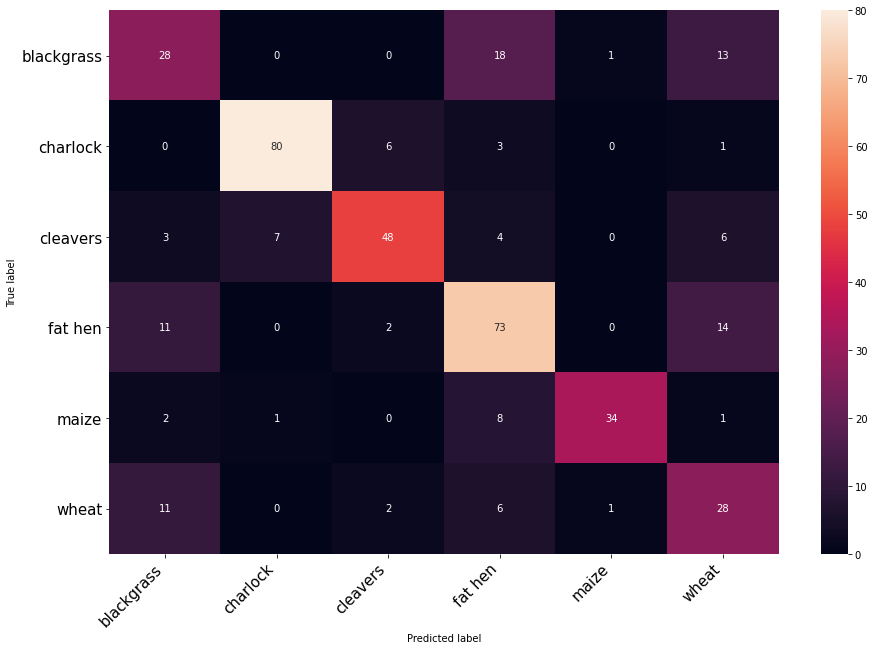

In [ ]:
#Train model
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                             num_epochs=25, device=device)


#Call test data
images, labels = next(iter(dataloaders['test']))
images = images.to(device)
#Send to tensorboard
writer.add_graph(model_conv, images)
#Time to test model
print("Testing model")
#Set confusion matric up as 6x6 (num of classes)
confusion_matrix = torch.zeros(6, 6)
#For loop for test and assigning to confusion matrix for multi class
with torch.no_grad():
    for i, (images, labels) in enumerate(dataloaders['test']):
        #Set images and labels to same device as model
        images = images.to(device)
        labels = labels.to(device)
        #Pass model image
        outputs = model_conv(images)
        #Compare model prediction with actual
        _, pred = torch.max(outputs, 1)
        #For loop to add to confusion matrix
        for t, p in zip(labels.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] +=1
#Print matrix created
print(confusion_matrix)
#Find each class accuracy
accuracy_individ = confusion_matrix.diag()/confusion_matrix.sum(1)
#Print each class accuracy
print(accuracy_individ)

#Plot figure for easier understanding of model
plt.figure(figsize=(15,10))
#Set to dataframe for seaborn heatmap
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
#Call heatmap with dataframe
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
#Call heatmap with dataframe
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
#Save for later use
conf = root_path + "Conf_matrix_Scratch-CNN.png"
plt.savefig(conf)



In [ ]:
#convert accuracies to numpy
accuracy_indi = accuracy_individ.numpy()
#Convert matrix to numpy
matrix = confusion_matrix.numpy()
#Total up each class verical from matrix
totals = np.sum(matrix, axis = 1)
#Total up each class horizontal from matrix
fp_total = np.sum(matrix, axis = 0)


overall_total = sum(totals + fp_total)
#Evaluation metrics for loop
for i in range(6):
  total = totals[i]
  TP = total * accuracy_indi[i]
  FN = total - TP
  FP = fp_total[i] - TP
  TN = overall_total -(total + fp_total[i])
  Accuracy = (TP + TN)/ (TP + FP + TN + FN)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  Specificity = TN / (TN + FP)
  F1 = (2*TP) / (2*TP + FP + FN)
  MCC = ((TP * TN) - (FP *FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) )
  Error_rate = (FP + FN)/ (TP + FP + TN + FN) 
  Sensitivity = TP / (TP +FN)
  print(class_names[i].capitalize())
  print("True Positive value = " + str(TP))
  print("False Negative value = " + str(FN))
  print("False Positive value = " + str(FP))
  print("True Negative value = " + str(TN))
  print("Accuracy = " + str(Accuracy))
  print("Precision = " + str(Precision))
  print("Recall = " + str(Recall))
  print("Specificity = " + str(Specificity))
  print("F1 Score = " + str(F1))
  print("MCC = " + str(MCC))
  print("Error Rate = " + str(Error_rate))
  print("Sensitivity = " + str(Sensitivity))
  print()

#Save the model for later use to be deployed using torchserve
s = torch.jit.script(model_conv)
torch.jit.save(s, root_path + 'Scratch-CNN.pt')

Blackgrass
True Positive value = 28.0
False Negative value = 32.0
False Positive value = 27.0
True Negative value = 709.0
Accuracy = 0.9258793969849246
Precision = 0.5090909
Recall = 0.46666667
Specificity = 0.9633152173913043
F1 Score = 0.48695652173913045
MCC = 0.44758367922413006
Error Rate = 0.07412060301507538
Sensitivity = 0.46666667

Charlock
True Positive value = 80.0
False Negative value = 10.0
False Positive value = 8.0
True Negative value = 646.0
Accuracy = 0.9758064516129032
Precision = 0.90909094
Recall = 0.8888889
Specificity = 0.9877675840978594
F1 Score = 0.898876404494382
MCC = 0.8852100113765115
Error Rate = 0.024193548387096774
Sensitivity = 0.8888889

Cleavers
True Positive value = 48.0
False Negative value = 20.0
False Positive value = 10.0
True Negative value = 698.0
Accuracy = 0.961340206185567
Precision = 0.82758623
Recall = 0.7058824
Specificity = 0.9858757062146892
F1 Score = 0.7619047619047619
MCC = 0.7437878740269229
Error Rate = 0.03865979381443299
Sensitiv

In [ ]:
!tensorboard dev upload \
  --logdir  runs/Scratch-CNN\
  --name "Scratch CNN Model" \
  --description "Relevant information on model found here" \
  --one_shot

2021-04-19 20:59:30.486120: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/FaurIX3OS9uNrQfeXfESvA/

[2021-04-19T20:59:32] Started scanning logdir.
E0419 20:59:33.540637 139760501368704 uploader.py:1114] Attempted to re-upload existing blob.  Skipping.
E0419 20:59:34.672464 139760501368704 uploader.py:1114] Attempted to re-upload existing blob.  Skipping.
E0419 20:59:35.569818 139760501368704 uploader.py:1114] Attempted to re-upload existing blob.  Skipping.
E0419 20:59:36.542143 139760501368704 uploader.py:1114] Attempted to re-upload existing blob.  Skipping.
[2021-04-19T20:59:36] Total uploaded: 260 scalars, 0 tensors, 1 binary objects (9.1 